 # Comparison of PCN and BioPCN on MNIST with two large hidden (linear) layers

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pydove as dv

import numpy as np
import torch
import time

from cpcn import *
from cpcn.graph import *

 ## Setup

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# for reproducibility
torch.manual_seed(123)

# get train, validation, and test loaders for MNIST
dataset = load_mnist(n_validation=500, device=device)

 ## Train PCN

In [3]:
n_batches = 2000
dims = [784, 50, 5, 10]
z_it = 50
z_lr = 0.07

t0 = time.time()
torch.manual_seed(123)

net = PCNetwork(
    dims,
    activation=lambda _: _,
    z_lr=z_lr,
    z_it=z_it,
    variances=1.0,
    # constrained=True,
    constrained=False,
    bias=False,
)
net = net.to(device)

optimizer = torch.optim.SGD(net.parameters(), lr=0.008)
trainer = Trainer(dataset["train"])
trainer.metrics["accuracy"] = one_hot_accuracy
for batch in tqdmw(trainer(n_batches)):
    if batch.every(10):
        batch.evaluate(dataset["validation"]).run(net)
        batch.weight.report("W", net.W)

    ns = batch.feed(net, latent_profile=True)
    batch.latent.report_batch("z", ns.fast.z)
    if batch.count(4):
        batch.fast.report_batch("z", [_.transpose(0, 1) for _ in ns.fast.profile.z])

    optimizer.step()

results = trainer.history
print(f"Training PCN took {time.time() - t0:.1f} seconds.")

  0%|          | 0/2000 [00:00<?, ?it/s]

Training PCN took 112.7 seconds.


 ### Show PCN learning curves

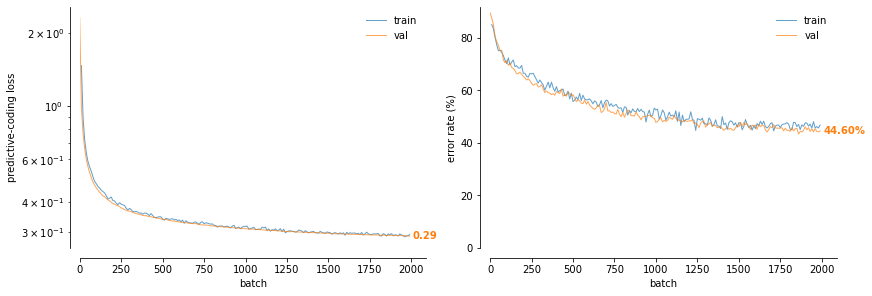

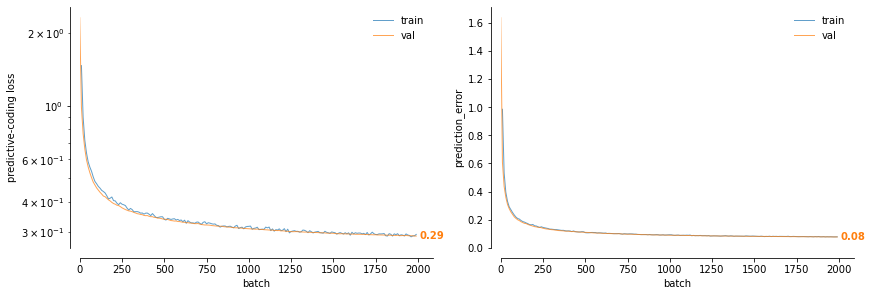

In [4]:
_ = show_learning_curves(results)
_ = show_learning_curves(results, var_names=("pc_loss", "prediction_error"))

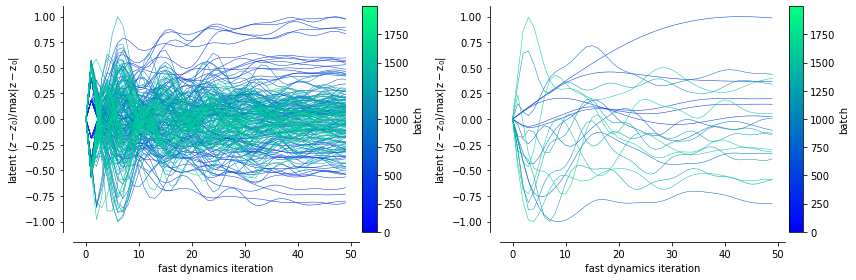

In [5]:
with dv.FigureManager(1, 2) as (_, (ax1, ax2)):
    show_latent_convergence(results.fast, layer=1, ax=ax1)
    show_latent_convergence(results.fast, layer=2, ax=ax2)

 ### Show covariance diagnostics

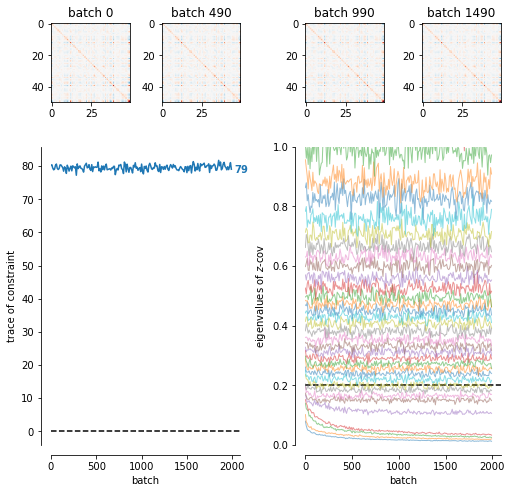

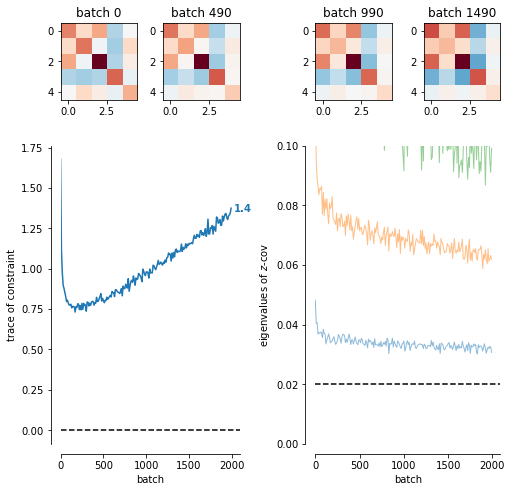

In [6]:
cons_diag = get_constraint_diagnostics(results.latent, rho=[1.0, 0.2, 0.02, 1.0])
_ = show_constraint_diagnostics(cons_diag, layer=1, rho=0.2)
_ = show_constraint_diagnostics(cons_diag, layer=2, rho=0.02)

 ## Train BioPCN

In [7]:
z_it = 50
z_lr = 0.02
Q_lr_factor = 6
# rho = [2.0, 0.3]
# rho = [1.0, 0.1]
# rho = [5.0, 0.5]
rho = [0.2, 0.02]
# rho = [0.05, 0.005]
# rho = 0.1
# rho = 0.0012

t0 = time.time()
torch.manual_seed(123)

# match the PCN network
g_a = 0.5 * np.ones(len(dims) - 2)
g_a[-1] *= 2

g_b = 0.5 * np.ones(len(dims) - 2)
g_b[0] *= 2

biopcn_net = LinearBioPCN(
    dims,
    z_lr=z_lr,
    z_it=z_it,
    g_a=g_a,
    g_b=g_b,
    c_m=0,
    # l_s=g_b,
    l_s=g_a + g_b,
    rho=rho,
    bias_a=False,
    bias_b=False,
    q0_scale=np.sqrt(1 + dims[2] / dims[1]),
)
biopcn_net = biopcn_net.to(device)

biopcn_optimizer = multi_lr(
    torch.optim.SGD,
    biopcn_net.parameter_groups(),
    lr_factors={"Q": Q_lr_factor, "W_a": 2},
    lr=0.012,
)
biopcn_trainer = Trainer(dataset["train"], invalid_action="warn+stop")
biopcn_trainer.metrics = trainer.metrics
for batch in tqdmw(biopcn_trainer(n_batches)):
    if batch.every(10):
        batch.evaluate(dataset["validation"]).run(biopcn_net)
        batch.weight.report(
            {"W_a": biopcn_net.W_a, "W_b": biopcn_net.W_b, "Q": biopcn_net.Q}
        )

    ns = batch.feed(biopcn_net, latent_profile=True)
    batch.latent.report_batch("z", ns.fast.z)
    if batch.count(4):
        batch.fast.report_batch("z", [_.transpose(0, 1) for _ in ns.fast.profile.z])

    biopcn_optimizer.step()

biopcn_results = biopcn_trainer.history
print(f"Training BioPCN took {time.time() - t0:.1f} seconds.")

  0%|          | 0/2000 [00:00<?, ?it/s]

Training BioPCN took 116.5 seconds.


 ### Show BioPCN learning curves

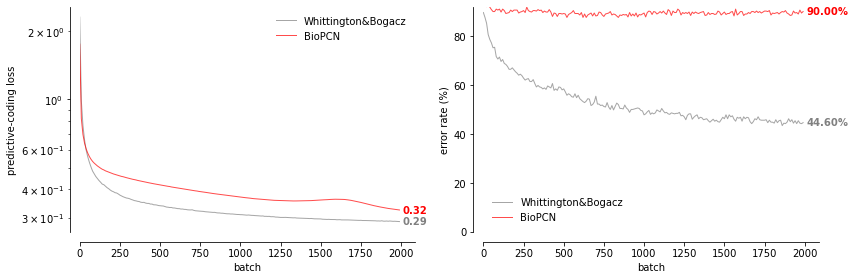

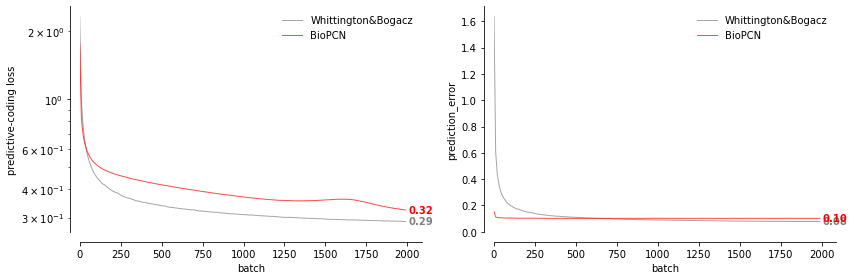

In [8]:
with dv.FigureManager(1, 2) as (_, axs):
    show_learning_curves(
        results,
        show_train=False,
        labels=("", "Whittington&Bogacz"),
        colors=("C0", "gray"),
        axs=axs,
    )
    show_learning_curves(
        biopcn_results,
        show_train=False,
        labels=("", "BioPCN"),
        colors=("C0", "red"),
        axs=axs,
    )

with dv.FigureManager(1, 2) as (_, axs):
    show_learning_curves(
        results,
        show_train=False,
        labels=("", "Whittington&Bogacz"),
        colors=("C0", "gray"),
        var_names=("pc_loss", "prediction_error"),
        axs=axs,
    )
    show_learning_curves(
        biopcn_results,
        show_train=False,
        labels=("", "BioPCN"),
        colors=("C0", "red"),
        var_names=("pc_loss", "prediction_error"),
        axs=axs,
    )

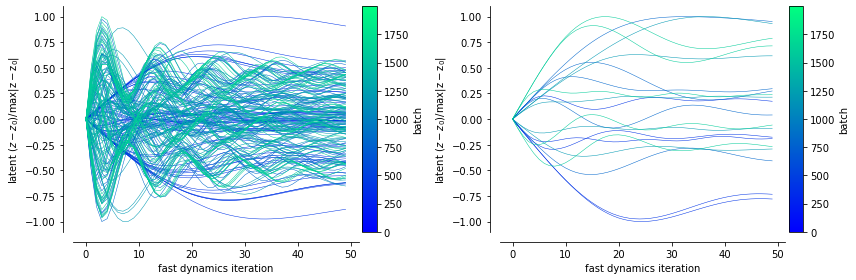

In [9]:
with dv.FigureManager(1, 2) as (_, (ax1, ax2)):
    show_latent_convergence(biopcn_results.fast, layer=1, ax=ax1)
    show_latent_convergence(biopcn_results.fast, layer=2, ax=ax2)

 ### Show covariance diagnostics

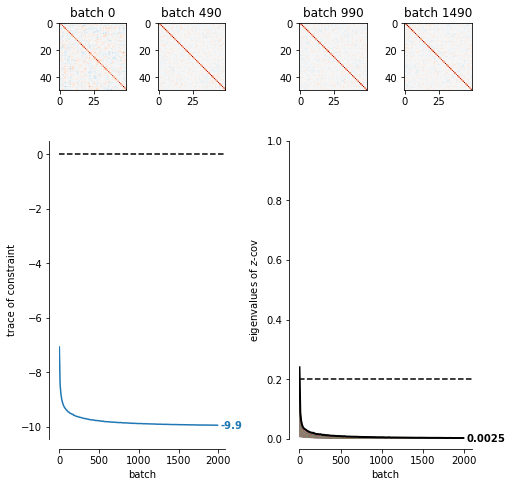

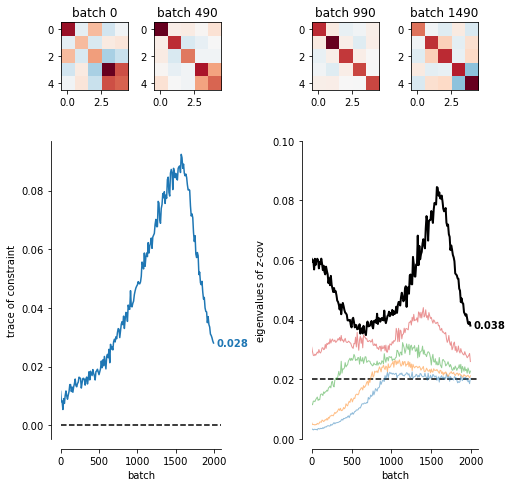

In [10]:
biopcn_cons_diag = get_constraint_diagnostics(
    biopcn_results.latent, rho=[1] + list(biopcn_net.rho) + [1]
)
_ = show_constraint_diagnostics(biopcn_cons_diag, layer=1, rho=biopcn_net.rho[0])
_ = show_constraint_diagnostics(biopcn_cons_diag, layer=2, rho=biopcn_net.rho[1])